Задача - multi-label классификация - освежить память что это значит (https://scikit-learn.org/stable/modules/multiclass.html).

Тартеты: 14 последних колонок - df.iloc[:,-14:]

Метрика: Micro averaged F1. Хорошо бы оценивать качество с помощью кросс-валидации.

- Построить baseline с использованием линейной модели из scikit-learn


- Чистый Tensorflow

Построить линейную модель для решения этой задачи. Можно взять существующий код из блокнота Tensorflow examples 1.ipynb и переделать.


- Keras

Сделать тоже самое как и в Tensorflow но использовав чистый Keras

Добавить слоёв и нелинейностей, сравнить качество моделей


In [1]:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade seaborn
!pip install --upgrade pprint
!pip install --upgrade tensorflow
#!pip install --upgrade contractions
#!pip install --upgrade wordcloud
#!pip install --upgrade umap-learn
#!pip install --upgrade gensim
#!pip install --upgrade pyldavis

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.24.1)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: tensorflow in c:\anaconda\lib\site-packages (1.12.0)


In [2]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
from time import time
from itertools import compress
from collections import Counter
#import glob
#import contractions
#from wordcloud import WordCloud
#import umap
#import unicodedata
#from bs4 import BeautifulSoup

#import time

#from scipy import interp

import pickle
sns.set(font_scale=1.3)

seed = 321

%matplotlib inline

In [3]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import confusion_matrix, classification_report,f1_score, make_scorer
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [35]:
import tensorflow as tf

In [5]:
import keras
import json
import operator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.metrics import binary_accuracy,categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


#### EDA.

read first ten row to understand, how to parse data.

In [7]:
x_data, y_data = pickle.load(open('data/task_2/reviews_dataset.pkl', 'rb'))

In [8]:
len(x_data)

769251

In [9]:
len(y_data)

769251

In [10]:
x_data[0]

'Потрясающе красивая графика космоса! Уже за это игру можно полюбить. Так же в наличии интересный осмысленный сюжет и удобное управление.'

In [11]:
y_data[0]

5

Baseline.

Обучить линейную модель на TF-IDF представлении для предсказания оценки пользователя по его отзыву. 

Посмотреть на важность для каждой оценки.

In [12]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text


#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

StopWords = list(set(stopwords.words('russian')))
'''
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie','sza']

#StopWords.extend(newStopWords)
#StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) ''';

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text


# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    # text to lowercase
    text =  text.lower()

    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')

       
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [13]:
%%time
test = tokenize(x_data[4])

Wall time: 2.03 s


In [14]:
test

['таки',
 'удержался',
 'написать',
 'топ',
 'скорей',
 'сотрут',
 'прочтет',
 'ужасной',
 'игры',
 'star',
 'war',
 'empire',
 'at',
 'war',
 'dvd',
 'ещё',
 'поискать',
 'нормального',
 'сюжета',
 'стратегия',
 'это',
 'вовсе',
 'провал',
 'давно',
 'убедился',
 'всё',
 'берётся',
 '1с',
 'плане',
 'игр',
 'отстой',
 'хорошая',
 'стратегия',
 'эпизодам',
 'star',
 'war',
 'это',
 'star',
 'war',
 'galactic',
 'battleground',
 'играл',
 'поймет']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

In [43]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3) # также используем н-граммы
                            )

In [44]:
%%time
vectorised_train_documents = vectorizer.fit_transform(x_train)
vectorised_test_documents = vectorizer.transform(x_test)

In [45]:
vectorised_train_documents.shape

(538475, 143312)

In [46]:
vectorised_test_documents.shape

(230776, 143312)

In [57]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [54]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

In [55]:
%%time
_,_, clf = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)

Wall time: 1min 45s


              precision    recall  f1-score   support

           1       0.41      0.57      0.48     16683
           2       0.16      0.22      0.19      9679
           3       0.24      0.34      0.28     17653
           4       0.34      0.41      0.37     33086
           5       0.89      0.76      0.82    153675

   micro avg       0.64      0.64      0.64    230776
   macro avg       0.41      0.46      0.43    230776
weighted avg       0.70      0.64      0.66    230776

Confusion matrix, without normalization
None


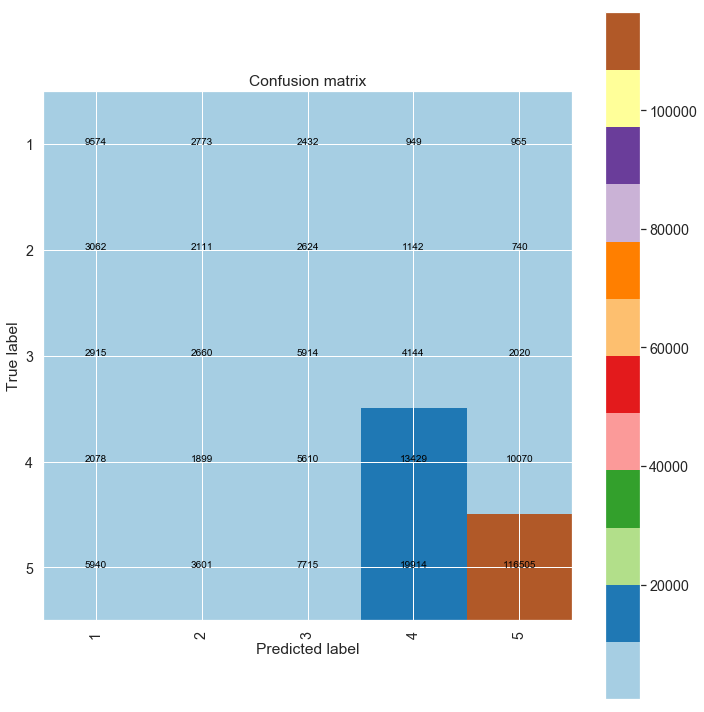

In [58]:
labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву. Использовать случайную инициализация весов.

- add stopwords?

In [19]:
#convert words to sequence
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,GlobalAveragePooling1D
from keras.datasets import imdb


In [20]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

In [94]:
%%time
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Wall time: 1min 34s


In [95]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [19]:
#y_train = np.array(y_train)
#y_test = np.array(y_test)

In [22]:
print (vocab_size)

print(x_train[0])

print(len(x_train[0]))

print(len(x_train))

485477
[851, 7, 12, 7, 3059, 3303, 4643, 618, 7, 44, 1, 12, 202, 257, 207, 2474, 466, 4, 4996, 1332, 1807, 51, 1203, 92, 1258, 3, 2526, 504, 1, 3278, 2034, 11, 2968, 629, 1336, 581, 52, 3, 546, 1109, 2282, 308, 108, 23, 2842, 144, 1202, 11, 925, 2968, 898, 52, 2431, 1758, 33, 3394, 546, 1109, 1686, 2, 4355, 1, 2, 3, 33, 3, 4441, 1075, 1, 365, 7, 1, 2034, 15, 2724, 11, 28, 20, 3633, 39, 1, 548, 13, 80, 4, 3817, 11, 1967, 1093, 3690, 19, 6, 2560, 1, 2, 1696, 828, 1, 39, 5, 9, 4132, 4398, 3, 7, 3059, 1786, 7, 3059, 2, 4, 3784, 102, 3817, 665, 1525, 3729, 6, 33, 14, 1708, 7, 3059, 879, 4643, 7, 2726, 10, 54, 15, 283, 558, 3611]
133
538475


In [24]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [25]:
print(x_train[0])

[  23 2842  144 1202   11  925 2968  898   52 2431 1758   33 3394  546 1109
 1686    2 4355    1    2    3   33    3 4441 1075    1  365    7    1 2034
   15 2724   11   28   20 3633   39    1  548   13   80    4 3817   11 1967
 1093 3690   19    6 2560    1    2 1696  828    1   39    5    9 4132 4398
    3    7 3059 1786    7 3059    2    4 3784  102 3817  665 1525 3729    6
   33   14 1708    7 3059  879 4643    7 2726   10   54   15  283  558 3611]


In [61]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 90
batch_size = 128
max_features = 20000

'''
vocab_size
embedding_dim = 50
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
                           
                           
model.add(Embedding(max_features, 128, input_length=maxlen))   


input_dim: the size of the vocabulary
output_dim: the size of the dense vector
input_length: the length of the sequence
                           ''';

In [64]:
max_features * 128

2560000

In [71]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim= 128, 
                    input_length=maxlen))#weights!
model.add(Bidirectional(LSTM(64)))# weights!
model.add(Dropout(0.1))
#model.add(Dropout(0.5)) #1
model.add(Dense(5, activation='softmax')) #softmax due to multiclass
earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 90, 128)           2560000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
Total params: 2,659,461
Trainable params: 2,659,461
Non-trainable params: 0
_________________________________________________________________


In [31]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = data[idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [67]:
x_train_part,y_train_part = next_batch(50000, x_train, y_train)
x_test_part,y_test_part = next_batch(16000, x_test, y_test)
#y_train_part = y_train

#x_test_part = x_test
#y_test_part = y_test

In [68]:
%%time
print('Train...')
model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=4,
          verbose = 2,
          callbacks=[earlyStopping],
          validation_data=[x_test_part, y_test_part])

Train...
Train on 50000 samples, validate on 16000 samples
Epoch 1/4
 - 211s - loss: 0.9431 - acc: 0.6700 - val_loss: 0.8425 - val_acc: 0.6909
Epoch 2/4
 - 213s - loss: 0.7835 - acc: 0.7082 - val_loss: 0.8160 - val_acc: 0.7054
Epoch 3/4
 - 215s - loss: 0.7266 - acc: 0.7260 - val_loss: 0.8172 - val_acc: 0.6991
Epoch 4/4
 - 200s - loss: 0.6871 - acc: 0.7397 - val_loss: 0.8345 - val_acc: 0.7001
Wall time: 14min 1s


In [69]:
y_predicted_scores = model.predict(x_test_part)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test_part, y_predicted_scores))

Classification report



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.64      0.21      0.32      1197
           1       0.00      0.00      0.00       629
           2       0.37      0.02      0.04      1206
           3       0.44      0.08      0.14      2264
           4       0.82      0.88      0.85     10704

   micro avg       0.80      0.62      0.70     16000
   macro avg       0.45      0.24      0.27     16000
weighted avg       0.68      0.62      0.61     16000
 samples avg       0.62      0.62      0.62     16000



In [60]:
'''print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=[x_test, y_test])

y_predicted_scores = model.predict(x_test)
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test, y_predicted_scores))''';

#### fasttext.

Обучить «fasttext» модель на n-граммах используя случайную инициализацию эмбедингов.

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = seed, test_size=0.3, shuffle=True)

In [21]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 2
max_features = 20000
maxlen = 400
batch_size = 128
embedding_dims = 50
epochs = 4

In [22]:
%%time
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Wall time: 1min 26s


In [25]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_y_train)
y_test = np_utils.to_categorical(encoded_y_test)

In [26]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

In [27]:
def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [28]:
'''print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))'''

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Adding 2-gram features
Average train sequence length: 54
Average test sequence length: 52
Pad sequences (samples x time)
x_train shape: (538475, 400)
x_test shape: (230776, 400)


In [29]:
vocab_size = x_train.max()#len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [42]:
x_train_part,y_train_part = next_batch(25000, x_train, y_train)
x_test_part,y_test_part = next_batch(11000, x_test, y_test)
#y_train_part = y_train

#x_test_part = x_test
#y_test_part = y_test

In [43]:
from tensorflow.contrib.opt import AdamWOptimizer

In [44]:
my_opt = AdamWOptimizer(0.01)

In [61]:
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
# используя случайную инициализацию эмбедингов
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dims,
                    input_length=maxlen, 
                    embeddings_initializer = 'RandomNormal')) 

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(5, activation='softmax'))

earlyStopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2, mode='max',restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              #optimizer = my_opt,
              optimizer='adam',
              metrics=['accuracy'])

#model.compile(loss='mse', optimizer=TFOptimizer(tf.train.GradientDescentOptimizer(0.1)))



model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 50)           103907450 
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 255       
Total params: 103,907,705
Trainable params: 103,907,705
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.fit(x_train_part, y_train_part,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[earlyStopping],
          validation_data=(x_test_part, y_test_part))

C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 103907450 elements. This may consume a large amount of memory.
  num_elements)
C:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:109: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 103907450 elements. This may consume a large amount of memory.
  num_elements)


Train on 25000 samples, validate on 11000 samples
Epoch 1/4
25000/25000 [==============================] - ETA: 48:45 - loss: 1.6167 - acc: 0.09 - ETA: 28:13 - loss: 1.6135 - acc: 0.10 - ETA: 22:06 - loss: 1.6099 - acc: 0.12 - ETA: 18:59 - loss: 1.6069 - acc: 0.25 - ETA: 16:55 - loss: 1.6043 - acc: 0.33 - ETA: 15:20 - loss: 1.6006 - acc: 0.39 - ETA: 14:06 - loss: 1.5980 - acc: 0.42 - ETA: 13:10 - loss: 1.5950 - acc: 0.45 - ETA: 12:25 - loss: 1.5927 - acc: 0.47 - ETA: 11:46 - loss: 1.5896 - acc: 0.48 - ETA: 11:28 - loss: 1.5857 - acc: 0.51 - ETA: 11:11 - loss: 1.5832 - acc: 0.52 - ETA: 10:50 - loss: 1.5806 - acc: 0.52 - ETA: 10:31 - loss: 1.5778 - acc: 0.53 - ETA: 10:20 - loss: 1.5745 - acc: 0.54 - ETA: 10:07 - loss: 1.5721 - acc: 0.55 - ETA: 9:54 - loss: 1.5690 - acc: 0.5570 - ETA: 9:43 - loss: 1.5654 - acc: 0.566 - ETA: 9:32 - loss: 1.5628 - acc: 0.569 - ETA: 9:21 - loss: 1.5600 - acc: 0.572 - ETA: 9:12 - loss: 1.5568 - acc: 0.577 - ETA: 9:02 - loss: 1.5540 - acc: 0.580 - ETA: 8:54 - 

25000/25000 [==============================] - ETA: 8:01 - loss: 1.0450 - acc: 0.664 - ETA: 8:18 - loss: 1.0631 - acc: 0.671 - ETA: 8:19 - loss: 1.0471 - acc: 0.671 - ETA: 8:25 - loss: 1.0762 - acc: 0.658 - ETA: 8:20 - loss: 1.1327 - acc: 0.635 - ETA: 8:13 - loss: 1.1299 - acc: 0.634 - ETA: 8:05 - loss: 1.1256 - acc: 0.637 - ETA: 7:58 - loss: 1.1196 - acc: 0.641 - ETA: 7:53 - loss: 1.1268 - acc: 0.638 - ETA: 7:53 - loss: 1.1275 - acc: 0.635 - ETA: 7:50 - loss: 1.1340 - acc: 0.632 - ETA: 7:45 - loss: 1.1203 - acc: 0.640 - ETA: 7:38 - loss: 1.1117 - acc: 0.644 - ETA: 7:31 - loss: 1.1142 - acc: 0.643 - ETA: 7:24 - loss: 1.1189 - acc: 0.640 - ETA: 7:18 - loss: 1.1139 - acc: 0.644 - ETA: 7:12 - loss: 1.1136 - acc: 0.643 - ETA: 7:06 - loss: 1.1040 - acc: 0.648 - ETA: 7:00 - loss: 1.1036 - acc: 0.648 - ETA: 6:55 - loss: 1.1008 - acc: 0.649 - ETA: 6:50 - loss: 1.1019 - acc: 0.649 - ETA: 6:44 - loss: 1.1076 - acc: 0.646 - ETA: 6:40 - loss: 1.1070 - acc: 0.647 - ETA: 6:35 - loss: 1.1060 - acc: 0

25000/25000 [==============================] - ETA: 7:47 - loss: 1.0153 - acc: 0.687 - ETA: 7:54 - loss: 1.0229 - acc: 0.683 - ETA: 7:49 - loss: 1.0690 - acc: 0.658 - ETA: 7:53 - loss: 1.0418 - acc: 0.673 - ETA: 7:53 - loss: 1.0355 - acc: 0.675 - ETA: 7:58 - loss: 1.0052 - acc: 0.688 - ETA: 7:55 - loss: 1.0198 - acc: 0.683 - ETA: 7:59 - loss: 1.0169 - acc: 0.688 - ETA: 7:59 - loss: 1.0334 - acc: 0.680 - ETA: 7:54 - loss: 1.0415 - acc: 0.675 - ETA: 7:52 - loss: 1.0341 - acc: 0.679 - ETA: 7:52 - loss: 1.0371 - acc: 0.676 - ETA: 7:50 - loss: 1.0372 - acc: 0.674 - ETA: 7:52 - loss: 1.0434 - acc: 0.670 - ETA: 7:49 - loss: 1.0424 - acc: 0.671 - ETA: 7:45 - loss: 1.0365 - acc: 0.674 - ETA: 7:42 - loss: 1.0438 - acc: 0.671 - ETA: 7:39 - loss: 1.0419 - acc: 0.671 - ETA: 7:36 - loss: 1.0410 - acc: 0.671 - ETA: 7:34 - loss: 1.0431 - acc: 0.670 - ETA: 7:31 - loss: 1.0461 - acc: 0.669 - ETA: 7:28 - loss: 1.0440 - acc: 0.670 - ETA: 7:26 - loss: 1.0470 - acc: 0.669 - ETA: 7:24 - loss: 1.0477 - acc: 0

In [63]:
y_predicted_scores = model.predict(x_test_part)

In [82]:
abc = tokenizer.sequences_to_texts(x_test_part)

In [83]:
abc # no ngrams!!! and wtf with optimizer???

['прекрасное продолжение серии добротный язык и симпатичные персонажи читается легко но хочется удовольствие эту серию иногда что слишком много главного героя но это основа сюжета книга не о мальчика а о том как наш успешно управления в условиях 12 века и в теле 12 летнего мальчика автор еще',
 'сомневаюсь что можно пройти первый раз эту за час через все ребенок все вряд ли что ребенок будет когда шарик падает к качеству замечаний нет завышена ли цена оценить не могу скорее больше за брали со скидкой',
 'долго выбирала и наконец выбрала коричневый открывать было немного вдруг не такой красивый как на фото очень красивый оказался замечательный просто и очень аккуратно выполнен для такой стоимости просто великолепно словом отличный красиво по',
 'уже писала отзыв на этот товар брала еще до ребенку уже 9 мес а я все еще не могу без большая и всего не ребенок мог бы до но я вовремя эти попытки благодаря ей в итоге малыш не окончательно из за какой нибудь мелочи и свой сон полностью как пол

In [65]:
y_predicted_scores[y_predicted_scores>=0.5] = 1
y_predicted_scores[y_predicted_scores<0.5] = 0

print('Classification report\n')
print(classification_report(y_test_part, y_predicted_scores))

Classification report



C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       836
           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00       898
           3       0.00      0.00      0.00      1520
           4       0.67      0.99      0.80      7301

   micro avg       0.67      0.66      0.66     11000
   macro avg       0.13      0.20      0.16     11000
weighted avg       0.44      0.66      0.53     11000
 samples avg       0.66      0.66      0.66     11000



In [64]:
'''Trains a Bidirectional LSTM on the IMDB sentiment classification task.
Output after 4 epochs on CPU: ~0.8146
Time per epoch on CPU (Core i7): ~150s.
'''

from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
batch_size = 32

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100


print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [70]:
(x_train[0])

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4,     2,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32])

In [68]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [69]:
x_train[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4,     2,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,    32])

In [59]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Loading data...
17465344/17464789 [==============================] - ETA: 4: - ETA: 1: - ETA: 59s - ETA: 34 - ETA: 28 - ETA: 16 - ETA: 16 - ETA: 11 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4


 6528/25000 [======>.......................] - ETA: 24:53 - loss: 0.6929 - acc: 0.50 - ETA: 13:26 - loss: 0.6941 - acc: 0.43 - ETA: 9:41 - loss: 0.6937 - acc: 0.4688 - ETA: 7:48 - loss: 0.6931 - acc: 0.507 - ETA: 6:39 - loss: 0.6929 - acc: 0.512 - ETA: 5:56 - loss: 0.6923 - acc: 0.531 - ETA: 5:26 - loss: 0.6919 - acc: 0.544 - ETA: 5:06 - loss: 0.6921 - acc: 0.550 - ETA: 4:48 - loss: 0.6927 - acc: 0.534 - ETA: 4:45 - loss: 0.6924 - acc: 0.537 - ETA: 4:33 - loss: 0.6929 - acc: 0.519 - ETA: 4:25 - loss: 0.6928 - acc: 0.520 - ETA: 4:16 - loss: 0.6925 - acc: 0.528 - ETA: 4:09 - loss: 0.6922 - acc: 0.535 - ETA: 4:02 - loss: 0.6931 - acc: 0.520 - ETA: 3:58 - loss: 0.6932 - acc: 0.511 - ETA: 3:53 - loss: 0.6937 - acc: 0.500 - ETA: 3:48 - loss: 0.6940 - acc: 0.498 - ETA: 3:43 - loss: 0.6938 - acc: 0.498 - ETA: 3:39 - loss: 0.6937 - acc: 0.503 - ETA: 3:35 - loss: 0.6936 - acc: 0.504 - ETA: 3:32 - loss: 0.6934 - acc: 0.511 - ETA: 3:28 - loss: 0.6933 - acc: 0.513 - ETA: 3:24 - loss: 0.6932 - acc: 

25000/25000 [==============================] - ETA: 26s - loss: 0.4288 - acc: 0.79 - ETA: 26s - loss: 0.4286 - acc: 0.79 - ETA: 26s - loss: 0.4287 - acc: 0.79 - ETA: 26s - loss: 0.4284 - acc: 0.79 - ETA: 26s - loss: 0.4284 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4280 - acc: 0.79 - ETA: 25s - loss: 0.4277 - acc: 0.79 - ETA: 25s - loss: 0.4278 - acc: 0.79 - ETA: 25s - loss: 0.4277 - acc: 0.79 - ETA: 24s - loss: 0.4275 - acc: 0.80 - ETA: 24s - loss: 0.4276 - acc: 0.79 - ETA: 24s - loss: 0.4275 - acc: 0.80 - ETA: 24s - loss: 0.4272 - acc: 0.80 - ETA: 24s - loss: 0.4273 - acc: 0.80 - ETA: 24s - loss: 0.4272 - acc: 0.80 - ETA: 23s - loss: 0.4270 - acc: 0.80 - ETA: 23s - loss: 0.4267 - acc: 0.80 - ETA: 23s - loss: 0.4264 - acc: 0.80 - ETA: 23s - loss: 0.4265 - acc: 0.80 - ETA: 23s - loss: 0.4261 - acc: 0.80 - ETA: 23s - loss: 0.4260 - acc: 0.80 - ETA: 22s - loss: 0.4260 - acc: 0.80 - ETA: 22s - loss: 0.4259 - acc: 0.80 - ETA

 6528/25000 [======>.......................] - ETA: 2:10 - loss: 0.1308 - acc: 0.968 - ETA: 2:09 - loss: 0.1917 - acc: 0.921 - ETA: 2:06 - loss: 0.1713 - acc: 0.927 - ETA: 2:05 - loss: 0.1675 - acc: 0.937 - ETA: 2:05 - loss: 0.1681 - acc: 0.943 - ETA: 2:03 - loss: 0.1731 - acc: 0.947 - ETA: 2:02 - loss: 0.1789 - acc: 0.937 - ETA: 2:02 - loss: 0.1817 - acc: 0.937 - ETA: 2:01 - loss: 0.1948 - acc: 0.934 - ETA: 2:02 - loss: 0.1969 - acc: 0.931 - ETA: 2:01 - loss: 0.2041 - acc: 0.929 - ETA: 2:01 - loss: 0.2060 - acc: 0.932 - ETA: 2:00 - loss: 0.2093 - acc: 0.932 - ETA: 2:00 - loss: 0.2090 - acc: 0.933 - ETA: 2:00 - loss: 0.2207 - acc: 0.927 - ETA: 2:00 - loss: 0.2184 - acc: 0.923 - ETA: 2:00 - loss: 0.2163 - acc: 0.924 - ETA: 1:59 - loss: 0.2179 - acc: 0.923 - ETA: 1:59 - loss: 0.2143 - acc: 0.924 - ETA: 1:59 - loss: 0.2067 - acc: 0.928 - ETA: 1:58 - loss: 0.2037 - acc: 0.928 - ETA: 1:58 - loss: 0.2074 - acc: 0.923 - ETA: 1:59 - loss: 0.2044 - acc: 0.923 - ETA: 1:59 - loss: 0.2016 - acc: 0

25000/25000 [==============================] - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2206 - acc: 0.91 - ETA: 26s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2211 - acc: 0.91 - ETA: 25s - loss: 0.2209 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2210 - acc: 0.91 - ETA: 25s - loss: 0.2209 - acc: 0.91 - ETA: 24s - loss: 0.2209 - acc: 0.91 - ETA: 24s - loss: 0.2208 - acc: 0.91 - ETA: 24s - loss: 0.2208 - acc: 0.91 - ETA: 24s - loss: 0.2210 - acc: 0.91 - ETA: 24s - loss: 0.2212 - acc: 0.91 - ETA: 24s - loss: 0.2213 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2215 - acc: 0.91 - ETA: 23s - loss: 0.2218 - acc: 0.91 - ETA: 23s - loss: 0.2217 - acc: 0.91 - ETA: 23s - loss: 0.2216 - acc: 0.91 - ETA: 22s - loss: 0.2218 - acc: 0.91 - ETA: 22s - loss: 0.2217 - acc: 0.91 - ETA: 22s - loss: 0.2220 - acc: 0.91 - ETA

 6528/25000 [======>.......................] - ETA: 2:05 - loss: 0.0988 - acc: 1.000 - ETA: 2:03 - loss: 0.0723 - acc: 1.000 - ETA: 2:03 - loss: 0.0668 - acc: 0.989 - ETA: 2:03 - loss: 0.1107 - acc: 0.968 - ETA: 2:05 - loss: 0.1002 - acc: 0.975 - ETA: 2:04 - loss: 0.1088 - acc: 0.968 - ETA: 2:04 - loss: 0.1061 - acc: 0.968 - ETA: 2:03 - loss: 0.1166 - acc: 0.968 - ETA: 2:03 - loss: 0.1548 - acc: 0.958 - ETA: 2:02 - loss: 0.1439 - acc: 0.962 - ETA: 2:02 - loss: 0.1361 - acc: 0.965 - ETA: 2:02 - loss: 0.1346 - acc: 0.963 - ETA: 2:02 - loss: 0.1298 - acc: 0.966 - ETA: 2:02 - loss: 0.1611 - acc: 0.950 - ETA: 2:02 - loss: 0.1590 - acc: 0.952 - ETA: 2:02 - loss: 0.1549 - acc: 0.953 - ETA: 2:01 - loss: 0.1486 - acc: 0.955 - ETA: 2:01 - loss: 0.1449 - acc: 0.958 - ETA: 2:01 - loss: 0.1427 - acc: 0.958 - ETA: 2:01 - loss: 0.1382 - acc: 0.959 - ETA: 2:01 - loss: 0.1332 - acc: 0.961 - ETA: 2:01 - loss: 0.1313 - acc: 0.963 - ETA: 2:01 - loss: 0.1304 - acc: 0.962 - ETA: 2:00 - loss: 0.1278 - acc: 0

25000/25000 [==============================] - ETA: 32s - loss: 0.1232 - acc: 0.95 - ETA: 32s - loss: 0.1231 - acc: 0.95 - ETA: 32s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1230 - acc: 0.95 - ETA: 31s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1231 - acc: 0.95 - ETA: 31s - loss: 0.1232 - acc: 0.95 - ETA: 31s - loss: 0.1232 - acc: 0.95 - ETA: 30s - loss: 0.1233 - acc: 0.95 - ETA: 30s - loss: 0.1233 - acc: 0.95 - ETA: 30s - loss: 0.1235 - acc: 0.95 - ETA: 30s - loss: 0.1236 - acc: 0.95 - ETA: 30s - loss: 0.1237 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1238 - acc: 0.95 - ETA: 29s - loss: 0.1237 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1236 - acc: 0.95 - ETA: 29s - loss: 0.1234 - acc: 0.95 - ETA: 28s - loss: 0.1234 - acc: 0.95 - ETA: 28s - loss: 0.1236 - acc: 0.95 - ETA: 28s - loss: 0.1239 - acc: 0.95 - ETA: 28s - loss: 0.1238 - acc: 0.95 - ETA: 28s - loss: 0.1240 - acc: 0.95 - ETA: 27s - loss: 0.1240 - acc: 0.95 - ETA

 6528/25000 [======>.......................] - ETA: 2:45 - loss: 0.0691 - acc: 0.968 - ETA: 2:43 - loss: 0.0463 - acc: 0.984 - ETA: 2:46 - loss: 0.0443 - acc: 0.989 - ETA: 2:48 - loss: 0.0442 - acc: 0.992 - ETA: 2:53 - loss: 0.0480 - acc: 0.987 - ETA: 2:57 - loss: 0.0575 - acc: 0.979 - ETA: 2:58 - loss: 0.0596 - acc: 0.977 - ETA: 2:59 - loss: 0.0604 - acc: 0.976 - ETA: 2:59 - loss: 0.0558 - acc: 0.979 - ETA: 2:59 - loss: 0.0516 - acc: 0.981 - ETA: 2:59 - loss: 0.0498 - acc: 0.983 - ETA: 3:00 - loss: 0.0593 - acc: 0.976 - ETA: 3:00 - loss: 0.0560 - acc: 0.978 - ETA: 2:59 - loss: 0.0632 - acc: 0.977 - ETA: 2:59 - loss: 0.0620 - acc: 0.979 - ETA: 2:59 - loss: 0.0611 - acc: 0.980 - ETA: 2:59 - loss: 0.0585 - acc: 0.981 - ETA: 2:59 - loss: 0.0592 - acc: 0.980 - ETA: 2:58 - loss: 0.0570 - acc: 0.981 - ETA: 2:58 - loss: 0.0558 - acc: 0.982 - ETA: 2:58 - loss: 0.0541 - acc: 0.983 - ETA: 2:56 - loss: 0.0526 - acc: 0.984 - ETA: 2:55 - loss: 0.0518 - acc: 0.985 - ETA: 2:55 - loss: 0.0519 - acc: 0

25000/25000 [==============================] - ETA: 35s - loss: 0.0744 - acc: 0.97 - ETA: 35s - loss: 0.0743 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0742 - acc: 0.97 - ETA: 34s - loss: 0.0743 - acc: 0.97 - ETA: 34s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 33s - loss: 0.0745 - acc: 0.97 - ETA: 32s - loss: 0.0744 - acc: 0.97 - ETA: 32s - loss: 0.0743 - acc: 0.97 - ETA: 32s - loss: 0.0746 - acc: 0.97 - ETA: 32s - loss: 0.0745 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0744 - acc: 0.97 - ETA: 31s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0745 - acc: 0.97 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 29s - loss: 0.0744 - acc: 0.97 - ETA